In [1]:
# load libraries and scripts
import JSON
using Plots
using HDF5
using Trapz
using Statistics
using SparseArrays
include("../scripts/tools.jl")
include("../scripts/get_grid.jl")
include("../scripts/get_params.jl")
include("../scripts/disturbances.jl")
include("../scripts/stable.jl")
include("../scripts/dynamics.jl")
include("../scripts/vectorize.jl")

vectorize (generic function with 1 method)

In [2]:
#load borders
border = import_border("../data/borders/border.json");

In [3]:
# create the lattice grid
dx = 20.0
Nx, Ny, xrange, yrange, isinside, isborder, n, isgrid = get_grid(border, Float64(dx));

In [21]:
# compute or load grid parameters
recompute_param = true
sigma = 200.0
if(recompute_param || !isfile("../numerics/grid_params_" * string(dx) * ".h5"))
    bx, by, p, m, d = get_params(isinside, isborder, n, Float64(dx), yrange, xrange, "../data/disc/pantagruel.h5",
        "../numerics/grid_params_" * string(dx) * ".h5", sigma=sigma)
else
    bx, by, p, m, d = get_params(isinside, "../numerics/grid_params_" * string(dx) * ".h5");
end

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [ ]:
minimum(bx[isgrid])

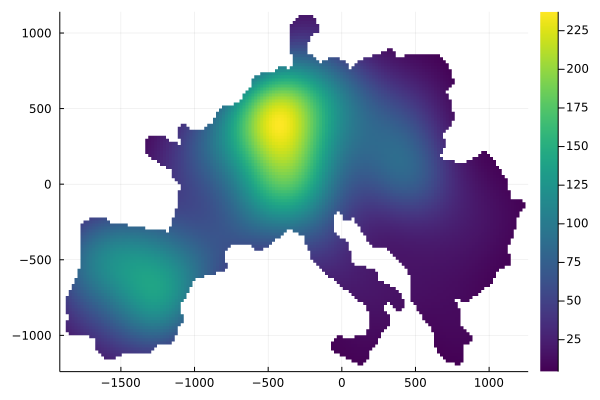

In [23]:
hm_plot(isgrid, xrange, yrange, bx)

In [ ]:
# compute or load grid parameters
recompute_param = true
# sigma = 100.0
if(recompute_param || !isfile("../numerics/grid_params_" * string(dx) * ".h5"))
    bx, by, p, m, d = get_params_diff(isinside, n, Float64(dx), yrange, xrange, "../data/disc/pantagruel.h5",
        "../numerics/grid_params_" * string(dx) * ".h5", Niter = 10000, dmax = 10.0, patch=0.003, bmin=0.01)
else
    bx, by, p, m, d = get_params(isinside, "../numerics/grid_params_" * string(dx) * ".h5");
end

In [24]:
th0, ~ = compute_stable_sol(isinside, n, bx, by, p);

[1000.0 0.0006266486112324055]
[2000.0 0.0003683106337124542]
[3000.0 0.00022331291435007117]
[4000.0 0.00014353274205958222]
[5000.0 9.740168336680455e-5]
[6000.0 7.575334614318141e-5]
[7000.0 6.2384075559474e-5]
[8000.0 5.113527576916521e-5]
[9000.0 4.1730732526668035e-5]
[10000.0 3.390057939256508e-5]
[11000.0 2.7398804098299756e-5]
[12000.0 2.2009530699973467e-5]
[13000.0 1.754752757787692e-5]
[14000.0 1.3856022282432434e-5]
[15000.0 1.1634191741549671e-5]
 29.175729 seconds (1.06 G allocations: 15.876 GiB, 2.25% gc time)


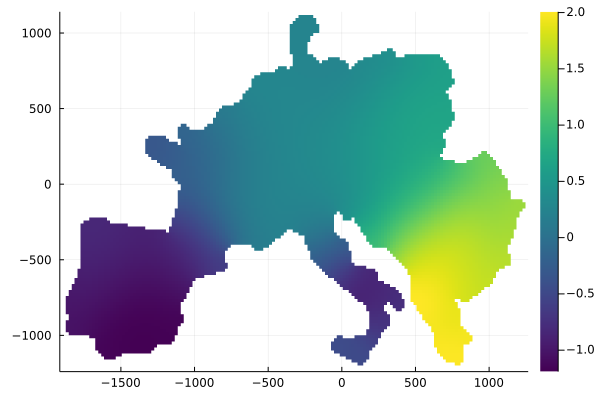

In [25]:
hm_plot(isgrid, xrange, yrange, th0)

In [ ]:
m = 1e-5 * ones(Ny, Nx)
d = 0.6 * m
bx = 8 * ones(Ny, Nx)
by = 8 * ones(Ny, Nx)
p = zeros(Ny, Nx)
m[.!isgrid] .= 0
d[.!isgrid] .= 0
p[.!isgrid] .= 0

In [26]:
isinsideflat, bxflat, byflat, pflat, minvflat, gammaflat, bflat, xneigh, yneigh = vectorize(isinside, n, bx, by, p, m, d);

Synchronized frequency: -0.1514590507257885


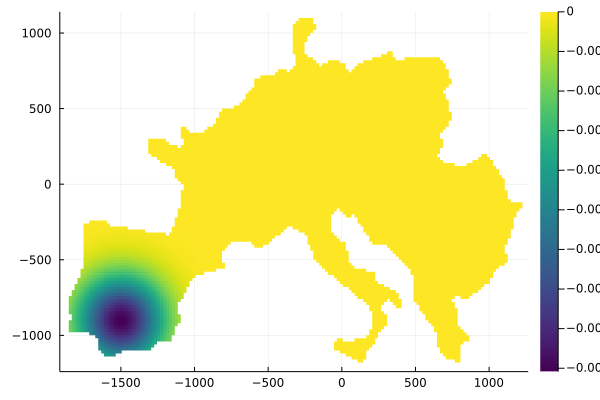

In [27]:
# define a disturbance
dP = -9.0
# dP = 0.0
sigma = 200.0
location = [-1500.0, -900.0]
dp = local_disturbance(isgrid, xrange, yrange, location, dP, sigma)
dpflat = vec(dp)
println("Synchronized frequency: ", trapz((yrange, xrange), p .+ dp) / trapz((yrange, xrange), d))
hm_plot(isinside, xrange, yrange, dp)


In [28]:
int = 200
dt = 0.0001
tf = 50.0
nit = tf / dt

ts, thetas, omegas = perform_dyn_sim_vec(isinsideflat, bxflat, byflat, xneigh, yneigh, bflat, pflat.+dpflat, minvflat, gammaflat, vec(th0), interval = int, Ndt = Int64(nit), dt = dt);

Total time: 50.0
NIter: 200 Avg. Omega: -0.0026794782331157427
NIter: 400 Avg. Omega: -0.005321707652444458
NIter: 600 Avg. Omega: -0.00789441890520584
NIter: 800 Avg. Omega: -0.010395037579349793
NIter: 1000 Avg. Omega: -0.012821297651955296
NIter: 1200 Avg. Omega: -0.015174559000868046
NIter: 1400 Avg. Omega: -0.01746117084830888
NIter: 1600 Avg. Omega: -0.019688592829386786
NIter: 1800 Avg. Omega: -0.02185990576656912
NIter: 2000 Avg. Omega: -0.023976762221521966
NIter: 2200 Avg. Omega: -0.026035557508685074
NIter: 2400 Avg. Omega: -0.028031081805951392
NIter: 2600 Avg. Omega: -0.029956003591892422
NIter: 2800 Avg. Omega: -0.03180344142523119
NIter: 3000 Avg. Omega: -0.033566797062196466
NIter: 3200 Avg. Omega: -0.03524076782038646
NIter: 3400 Avg. Omega: -0.036822204553148365
NIter: 3600 Avg. Omega: -0.0383158318482989
NIter: 3800 Avg. Omega: -0.03972550357909657
NIter: 4000 Avg. Omega: -0.04105691352196348
NIter: 4200 Avg. Omega: -0.04231801412696085
NIter: 4400 Avg. Omega: -0.043

NIter: 35800 Avg. Omega: -0.0553625716133634
NIter: 36000 Avg. Omega: -0.056358329027080385
NIter: 36200 Avg. Omega: -0.057327270519879854
NIter: 36400 Avg. Omega: -0.058269076337349034
NIter: 36600 Avg. Omega: -0.05918084165052052
NIter: 36800 Avg. Omega: -0.060063403687367636
NIter: 37000 Avg. Omega: -0.06091598101140745
NIter: 37200 Avg. Omega: -0.06174034525193218
NIter: 37400 Avg. Omega: -0.06253714514436956
NIter: 37600 Avg. Omega: -0.06330393285511102
NIter: 37800 Avg. Omega: -0.0640404813504258
NIter: 38000 Avg. Omega: -0.06474245163040622
NIter: 38200 Avg. Omega: -0.06540838646267443
NIter: 38400 Avg. Omega: -0.06603481093940315
NIter: 38600 Avg. Omega: -0.06662211663644847
NIter: 38800 Avg. Omega: -0.06716781670993262
NIter: 39000 Avg. Omega: -0.06767309564212318
NIter: 39200 Avg. Omega: -0.06814112443089343
NIter: 39400 Avg. Omega: -0.0685720551112033
NIter: 39600 Avg. Omega: -0.0689699102997275
NIter: 39800 Avg. Omega: -0.0693362585853505
NIter: 40000 Avg. Omega: -0.0696714

NIter: 71600 Avg. Omega: -0.06307853975581748
NIter: 71800 Avg. Omega: -0.06364308711325233
NIter: 72000 Avg. Omega: -0.06417918002723953
NIter: 72200 Avg. Omega: -0.06468785078092291
NIter: 72400 Avg. Omega: -0.06516996192090013
NIter: 72600 Avg. Omega: -0.0656248582258444
NIter: 72800 Avg. Omega: -0.06605482329714799
NIter: 73000 Avg. Omega: -0.0664574078154982
NIter: 73200 Avg. Omega: -0.06683531516696686
NIter: 73400 Avg. Omega: -0.06718715429320431
NIter: 73600 Avg. Omega: -0.06751499756872571
NIter: 73800 Avg. Omega: -0.06781861299975644
NIter: 74000 Avg. Omega: -0.06809875889647063
NIter: 74200 Avg. Omega: -0.06835718798123301
NIter: 74400 Avg. Omega: -0.06859487613062128
NIter: 74600 Avg. Omega: -0.06881325290088565
NIter: 74800 Avg. Omega: -0.06901384096938527
NIter: 75000 Avg. Omega: -0.06919818636777492
NIter: 75200 Avg. Omega: -0.0693661757400965
NIter: 75400 Avg. Omega: -0.06952016412981907
NIter: 75600 Avg. Omega: -0.06965997028327527
NIter: 75800 Avg. Omega: -0.069786772

NIter: 107000 Avg. Omega: -0.06225230458511979
NIter: 107200 Avg. Omega: -0.06251023667000154
NIter: 107400 Avg. Omega: -0.06274700913012157
NIter: 107600 Avg. Omega: -0.06296210112946034
NIter: 107800 Avg. Omega: -0.06315545994101038
NIter: 108000 Avg. Omega: -0.06332715792045791
NIter: 108200 Avg. Omega: -0.06347756646475514
NIter: 108400 Avg. Omega: -0.06360839712251948
NIter: 108600 Avg. Omega: -0.06371991378949417
NIter: 108800 Avg. Omega: -0.06381252288741128
NIter: 109000 Avg. Omega: -0.06388819004779406
NIter: 109200 Avg. Omega: -0.06394607531830072
NIter: 109400 Avg. Omega: -0.06398735208765936
NIter: 109600 Avg. Omega: -0.06401155797304246
NIter: 109800 Avg. Omega: -0.06401875375376238
NIter: 110000 Avg. Omega: -0.06401242989805532
NIter: 110200 Avg. Omega: -0.06399144194990858
NIter: 110400 Avg. Omega: -0.06395832661027624
NIter: 110600 Avg. Omega: -0.06391536139268787
NIter: 110800 Avg. Omega: -0.06386352356274652
NIter: 111000 Avg. Omega: -0.06380572437146692
NIter: 111200

NIter: 142000 Avg. Omega: -0.05938790172985042
NIter: 142200 Avg. Omega: -0.05943460484659827
NIter: 142400 Avg. Omega: -0.05947949613971144
NIter: 142600 Avg. Omega: -0.05952221295496239
NIter: 142800 Avg. Omega: -0.059562013929117794
NIter: 143000 Avg. Omega: -0.059599511161378294
NIter: 143200 Avg. Omega: -0.05963451812486278
NIter: 143400 Avg. Omega: -0.05966555212779305
NIter: 143600 Avg. Omega: -0.05969366427127535
NIter: 143800 Avg. Omega: -0.059715985432060234
NIter: 144000 Avg. Omega: -0.059733309831090896
NIter: 144200 Avg. Omega: -0.05974534348038234
NIter: 144400 Avg. Omega: -0.059751300473185935
NIter: 144600 Avg. Omega: -0.059752004796464
NIter: 144800 Avg. Omega: -0.059747368136734265
NIter: 145000 Avg. Omega: -0.0597376451541029
NIter: 145200 Avg. Omega: -0.059724511189600545
NIter: 145400 Avg. Omega: -0.05970821063437879
NIter: 145600 Avg. Omega: -0.05968801470615828
NIter: 145800 Avg. Omega: -0.05966639840454783
NIter: 146000 Avg. Omega: -0.05964063629631989
NIter: 14

NIter: 176800 Avg. Omega: -0.06010206203818167
NIter: 177000 Avg. Omega: -0.06011047320823844
NIter: 177200 Avg. Omega: -0.06011674797096177
NIter: 177400 Avg. Omega: -0.060117905706508684
NIter: 177600 Avg. Omega: -0.06011578554387754
NIter: 177800 Avg. Omega: -0.060111147827412295
NIter: 178000 Avg. Omega: -0.06010049478655624
NIter: 178200 Avg. Omega: -0.060088130175225275
NIter: 178400 Avg. Omega: -0.06007198010216893
NIter: 178600 Avg. Omega: -0.06005095041170684
NIter: 178800 Avg. Omega: -0.06002918850096238
NIter: 179000 Avg. Omega: -0.0600011446310198
NIter: 179200 Avg. Omega: -0.05997148907654751
NIter: 179400 Avg. Omega: -0.059938336759098154
NIter: 179600 Avg. Omega: -0.059900705647645845
NIter: 179800 Avg. Omega: -0.05986111345168741
NIter: 180000 Avg. Omega: -0.05981732646917327
NIter: 180200 Avg. Omega: -0.05977006137631446
NIter: 180400 Avg. Omega: -0.059721405538581414
NIter: 180600 Avg. Omega: -0.05966936405565711
NIter: 180800 Avg. Omega: -0.05961497483295342
NIter: 1

NIter: 211600 Avg. Omega: -0.05937275174187912
NIter: 211800 Avg. Omega: -0.0593848380367658
NIter: 212000 Avg. Omega: -0.05939151456940763
NIter: 212200 Avg. Omega: -0.05939738406827935
NIter: 212400 Avg. Omega: -0.0594018197530936
NIter: 212600 Avg. Omega: -0.05940130170541644
NIter: 212800 Avg. Omega: -0.05940092255212968
NIter: 213000 Avg. Omega: -0.059397986437131324
NIter: 213200 Avg. Omega: -0.05938912410904652
NIter: 213400 Avg. Omega: -0.0593812999774001
NIter: 213600 Avg. Omega: -0.05936786941709297
NIter: 213800 Avg. Omega: -0.05935210492288628
NIter: 214000 Avg. Omega: -0.05933632269854826
NIter: 214200 Avg. Omega: -0.059312853223249286
NIter: 214400 Avg. Omega: -0.059290195711965234
NIter: 214600 Avg. Omega: -0.059263982198283806
NIter: 214800 Avg. Omega: -0.0592333419962422
NIter: 215000 Avg. Omega: -0.05920347601775869
NIter: 215200 Avg. Omega: -0.05916804214892607
NIter: 215400 Avg. Omega: -0.059130387138247226
NIter: 215600 Avg. Omega: -0.059094261577906586
NIter: 2158

NIter: 246400 Avg. Omega: -0.05809448158723734
NIter: 246600 Avg. Omega: -0.05810324616390844
NIter: 246800 Avg. Omega: -0.058110573866759774
NIter: 247000 Avg. Omega: -0.058122273134058676
NIter: 247200 Avg. Omega: -0.05812878500591935
NIter: 247400 Avg. Omega: -0.058140007852881
NIter: 247600 Avg. Omega: -0.05814946225105041
NIter: 247800 Avg. Omega: -0.0581526388465142
NIter: 248000 Avg. Omega: -0.05816234486261796
NIter: 248200 Avg. Omega: -0.058169730330464
NIter: 248400 Avg. Omega: -0.058173818502665106
NIter: 248600 Avg. Omega: -0.05818163652479263
NIter: 248800 Avg. Omega: -0.05818129771563844
NIter: 249000 Avg. Omega: -0.05818608221840339
NIter: 249200 Avg. Omega: -0.05819243079516144
NIter: 249400 Avg. Omega: -0.0581889482520777
NIter: 249600 Avg. Omega: -0.05819212114322288
NIter: 249800 Avg. Omega: -0.05818991735772306
NIter: 250000 Avg. Omega: -0.05818778914575182
NIter: 250200 Avg. Omega: -0.05818979337268572
NIter: 250400 Avg. Omega: -0.058180958260278845
NIter: 250600 A

NIter: 281400 Avg. Omega: -0.057865299375740344
NIter: 281600 Avg. Omega: -0.05787281287673728
NIter: 281800 Avg. Omega: -0.05786966774225336
NIter: 282000 Avg. Omega: -0.057867207635276814
NIter: 282200 Avg. Omega: -0.057866014193802336
NIter: 282400 Avg. Omega: -0.057855242449107946
NIter: 282600 Avg. Omega: -0.0578598927521675
NIter: 282800 Avg. Omega: -0.057858017292756
NIter: 283000 Avg. Omega: -0.05784560374095834
NIter: 283200 Avg. Omega: -0.057845052730939206
NIter: 283400 Avg. Omega: -0.057836883480034636
NIter: 283600 Avg. Omega: -0.05783393510538212
NIter: 283800 Avg. Omega: -0.057832534864120974
NIter: 284000 Avg. Omega: -0.057813984144475104
NIter: 284200 Avg. Omega: -0.05781186702737165
NIter: 284400 Avg. Omega: -0.057806460347253515
NIter: 284600 Avg. Omega: -0.057794563264901413
NIter: 284800 Avg. Omega: -0.05778967141544331
NIter: 285000 Avg. Omega: -0.05777185817935218
NIter: 285200 Avg. Omega: -0.0577637272587094
NIter: 285400 Avg. Omega: -0.05776064408164009
NIter: 

NIter: 316200 Avg. Omega: -0.057847057154643174
NIter: 316400 Avg. Omega: -0.057835729492187654
NIter: 316600 Avg. Omega: -0.057815895747345795
NIter: 316800 Avg. Omega: -0.05781995638511165
NIter: 317000 Avg. Omega: -0.057807636691237486
NIter: 317200 Avg. Omega: -0.05780965890928285
NIter: 317400 Avg. Omega: -0.057801699118312865
NIter: 317600 Avg. Omega: -0.05777647748558789
NIter: 317800 Avg. Omega: -0.05778510332885621
NIter: 318000 Avg. Omega: -0.05777865985689259
NIter: 318200 Avg. Omega: -0.05776487864757481
NIter: 318400 Avg. Omega: -0.05776130268041278
NIter: 318600 Avg. Omega: -0.05773875452223984
NIter: 318800 Avg. Omega: -0.057744050137695874
NIter: 319000 Avg. Omega: -0.05774344419159263
NIter: 319200 Avg. Omega: -0.05771779043278607
NIter: 319400 Avg. Omega: -0.05771632255407127
NIter: 319600 Avg. Omega: -0.057704925451999525
NIter: 319800 Avg. Omega: -0.05770114423051717
NIter: 320000 Avg. Omega: -0.057701976200188326
NIter: 320200 Avg. Omega: -0.057673759614393215
NIte

NIter: 351200 Avg. Omega: -0.05772403073745607
NIter: 351400 Avg. Omega: -0.05775696131432389
NIter: 351600 Avg. Omega: -0.05774250398992946
NIter: 351800 Avg. Omega: -0.057733565182396376
NIter: 352000 Avg. Omega: -0.05773637934648923
NIter: 352200 Avg. Omega: -0.057716855646864546
NIter: 352400 Avg. Omega: -0.0577459162804402
NIter: 352600 Avg. Omega: -0.05773771593239133
NIter: 352800 Avg. Omega: -0.05770922959268694
NIter: 353000 Avg. Omega: -0.05772613998927721
NIter: 353200 Avg. Omega: -0.05771882043776837
NIter: 353400 Avg. Omega: -0.05772541499174109
NIter: 353600 Avg. Omega: -0.05772702956211716
NIter: 353800 Avg. Omega: -0.05769012507224301
NIter: 354000 Avg. Omega: -0.05771211287509339
NIter: 354200 Avg. Omega: -0.05772091651714384
NIter: 354400 Avg. Omega: -0.05769974199193977
NIter: 354600 Avg. Omega: -0.057707484078951266
NIter: 354800 Avg. Omega: -0.0576815170185497
NIter: 355000 Avg. Omega: -0.05769658456135434
NIter: 355200 Avg. Omega: -0.057715512757319176
NIter: 3554

NIter: 386200 Avg. Omega: -0.057656368338619424
NIter: 386400 Avg. Omega: -0.05763527952257582
NIter: 386600 Avg. Omega: -0.057683489840956274
NIter: 386800 Avg. Omega: -0.05765653365033224
NIter: 387000 Avg. Omega: -0.05767194564972778
NIter: 387200 Avg. Omega: -0.05765968175799826
NIter: 387400 Avg. Omega: -0.05762374649433164
NIter: 387600 Avg. Omega: -0.05768495104268702
NIter: 387800 Avg. Omega: -0.05766688045572296
NIter: 388000 Avg. Omega: -0.05763925948784473
NIter: 388200 Avg. Omega: -0.057659785941489294
NIter: 388400 Avg. Omega: -0.057631471646839134
NIter: 388600 Avg. Omega: -0.0576722750015129
NIter: 388800 Avg. Omega: -0.05767325456853821
NIter: 389000 Avg. Omega: -0.057611647755369186
NIter: 389200 Avg. Omega: -0.057653973770130096
NIter: 389400 Avg. Omega: -0.057650737418562026
NIter: 389600 Avg. Omega: -0.05764889935151071
NIter: 389800 Avg. Omega: -0.05766475712939598
NIter: 390000 Avg. Omega: -0.057601716011999766
NIter: 390200 Avg. Omega: -0.05764214590140538
NIter:

NIter: 421200 Avg. Omega: -0.057688427957208174
NIter: 421400 Avg. Omega: -0.05759669999180705
NIter: 421600 Avg. Omega: -0.05758814541658544
NIter: 421800 Avg. Omega: -0.05764832852035309
NIter: 422000 Avg. Omega: -0.05760054273626787
NIter: 422200 Avg. Omega: -0.057660850861158505
NIter: 422400 Avg. Omega: -0.05760658990315781
NIter: 422600 Avg. Omega: -0.057557254929962415
NIter: 422800 Avg. Omega: -0.057668317517580496
NIter: 423000 Avg. Omega: -0.05761368038962554
NIter: 423200 Avg. Omega: -0.05760950750147642
NIter: 423400 Avg. Omega: -0.0576187277753758
NIter: 423600 Avg. Omega: -0.05755525219269144
NIter: 423800 Avg. Omega: -0.05766102304291346
NIter: 424000 Avg. Omega: -0.057635408026319834
NIter: 424200 Avg. Omega: -0.05755794087208348
NIter: 424400 Avg. Omega: -0.05762362691995443
NIter: 424600 Avg. Omega: -0.057583538269637136
NIter: 424800 Avg. Omega: -0.05763099779873442
NIter: 425000 Avg. Omega: -0.0576452320477682
NIter: 425200 Avg. Omega: -0.0575292198611678
NIter: 425

NIter: 456000 Avg. Omega: -0.05753456924163777
NIter: 456200 Avg. Omega: -0.05759415301022429
NIter: 456400 Avg. Omega: -0.05775242589463251
NIter: 456600 Avg. Omega: -0.057552505158584
NIter: 456800 Avg. Omega: -0.05757705476678802
NIter: 457000 Avg. Omega: -0.0576190323763199
NIter: 457200 Avg. Omega: -0.057584185598948116
NIter: 457400 Avg. Omega: -0.05773388981391393
NIter: 457600 Avg. Omega: -0.057553495772779635
NIter: 457800 Avg. Omega: -0.057517309589522475
NIter: 458000 Avg. Omega: -0.057693958504094076
NIter: 458200 Avg. Omega: -0.057598409548554046
NIter: 458400 Avg. Omega: -0.05765330121149488
NIter: 458600 Avg. Omega: -0.0575845995590171
NIter: 458800 Avg. Omega: -0.05749534504418347
NIter: 459000 Avg. Omega: -0.05772287955630442
NIter: 459200 Avg. Omega: -0.05763150483596813
NIter: 459400 Avg. Omega: -0.057549115755252324
NIter: 459600 Avg. Omega: -0.05762155890394346
NIter: 459800 Avg. Omega: -0.05752849582740275
NIter: 460000 Avg. Omega: -0.05769599996893263
NIter: 4602

NIter: 491000 Avg. Omega: -0.05774122852230887
NIter: 491200 Avg. Omega: -0.057350420873967974
NIter: 491400 Avg. Omega: -0.0575823570672687
NIter: 491600 Avg. Omega: -0.0578629567009889
NIter: 491800 Avg. Omega: -0.05756024173699407
NIter: 492000 Avg. Omega: -0.05760400458186198
NIter: 492200 Avg. Omega: -0.057478601043699486
NIter: 492400 Avg. Omega: -0.05758198232771316
NIter: 492600 Avg. Omega: -0.057913089573187616
NIter: 492800 Avg. Omega: -0.05749406661936915
NIter: 493000 Avg. Omega: -0.057458175411964574
NIter: 493200 Avg. Omega: -0.057667194574118175
NIter: 493400 Avg. Omega: -0.0576071891668257
NIter: 493600 Avg. Omega: -0.05781313057328465
NIter: 493800 Avg. Omega: -0.05749982725778494
NIter: 494000 Avg. Omega: -0.05737220708952127
NIter: 494200 Avg. Omega: -0.057819535572358235
NIter: 494400 Avg. Omega: -0.05765162972914227
NIter: 494600 Avg. Omega: -0.057611209513897026
NIter: 494800 Avg. Omega: -0.05755884951720465
NIter: 495000 Avg. Omega: -0.057397719305373046
NIter: 4

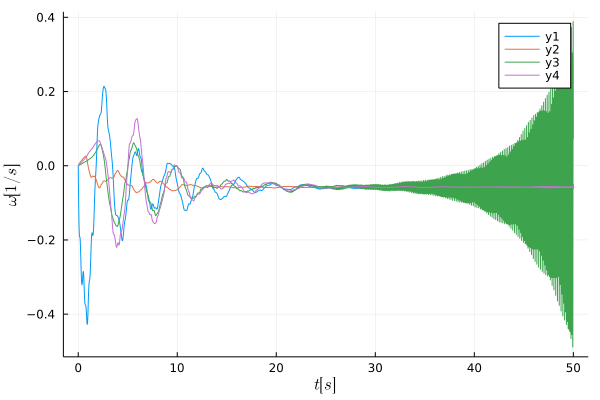

In [29]:
start=1
plot(0:0.02:tf,omegas[20,20,start:end])
plot!(0:0.02:tf,omegas[60,80,start:end])
plot!(0:0.02:tf,omegas[10,100,start:end])
plot!(0:0.02:tf,omegas[24,121,start:end])
xlabel!("\$t[s]\$")
ylabel!("\$\\omega[1/s]\$")

In [18]:
ts2, thetas2, omegas2 = perform_dyn_sim(isinside, n, bx, by, p.+dp, m, d, th0, interval=200, Ndt=Int64(3E5))

NIter: 200 Omega: -0.0026440777757512266
NIter: 400 Omega: -0.005251757428732678
NIter: 600 Omega: -0.00782653517333854
NIter: 800 Omega: -0.010344424846941872
NIter: 1000 Omega: -0.012809582675662992
NIter: 1200 Omega: -0.015223605397523647
NIter: 1400 Omega: -0.017581963463333804
NIter: 1600 Omega: -0.019887023372264487
NIter: 1800 Omega: -0.022140266660470285
NIter: 2000 Omega: -0.02434666498733983
NIter: 2200 Omega: -0.026508225869351202
NIter: 2400 Omega: -0.02862639372147225
NIter: 2600 Omega: -0.03070360662480316
NIter: 2800 Omega: -0.032739899064509505
NIter: 3000 Omega: -0.03473335805213866
NIter: 3200 Omega: -0.03668280861054129
NIter: 3400 Omega: -0.03858695187877174
NIter: 3600 Omega: -0.04044196321821652
NIter: 3800 Omega: -0.042245902472851975
NIter: 4000 Omega: -0.043996666615808325
NIter: 4200 Omega: -0.04569074530955748
NIter: 4400 Omega: -0.0473276088936789
NIter: 4600 Omega: -0.048905557639159186
NIter: 4800 Omega: -0.05042309966114061
NIter: 5000 Omega: -0.051881710

NIter: 40200 Omega: -0.050970305283121936
NIter: 40400 Omega: -0.05196657712693541
NIter: 40600 Omega: -0.05297370107142104
NIter: 40800 Omega: -0.053990409694249744
NIter: 41000 Omega: -0.05501407092283288
NIter: 41200 Omega: -0.05604243420426617
NIter: 41400 Omega: -0.05707325534849266
NIter: 41600 Omega: -0.05810382788105364
NIter: 41800 Omega: -0.059132474226725004
NIter: 42000 Omega: -0.060157166536471664
NIter: 42200 Omega: -0.061176478175340186
NIter: 42400 Omega: -0.06218901189475284
NIter: 42600 Omega: -0.06319294461504704
NIter: 42800 Omega: -0.06418817440371115
NIter: 43000 Omega: -0.0651729711619826
NIter: 43200 Omega: -0.06614683729660574
NIter: 43400 Omega: -0.06710898054456625
NIter: 43600 Omega: -0.06805833487405741
NIter: 43800 Omega: -0.06899571998444104
NIter: 44000 Omega: -0.06992069227714459
NIter: 44200 Omega: -0.07083359589248495
NIter: 44400 Omega: -0.07173392426722167
NIter: 44600 Omega: -0.07262137816255529
NIter: 44800 Omega: -0.07349670001070524
NIter: 45000

NIter: 80400 Omega: -0.061404472225101564
NIter: 80600 Omega: -0.06144845603974558
NIter: 80800 Omega: -0.06151474418029405
NIter: 81000 Omega: -0.06160401579601831
NIter: 81200 Omega: -0.061716235116905556
NIter: 81400 Omega: -0.061850439105369755
NIter: 81600 Omega: -0.06200575429958079
NIter: 81800 Omega: -0.06218107600883338
NIter: 82000 Omega: -0.062375507078636434
NIter: 82200 Omega: -0.06258753795714776
NIter: 82400 Omega: -0.06281542939105415
NIter: 82600 Omega: -0.06305848786241547
NIter: 82800 Omega: -0.06331471102072214
NIter: 83000 Omega: -0.06358271809601324
NIter: 83200 Omega: -0.06386190800515232
NIter: 83400 Omega: -0.06415100825905573
NIter: 83600 Omega: -0.06444958730411147
NIter: 83800 Omega: -0.06475639235079003
NIter: 84000 Omega: -0.06507165304801946
NIter: 84200 Omega: -0.06539460257992188
NIter: 84400 Omega: -0.06572529548065574
NIter: 84600 Omega: -0.06606477655882864
NIter: 84800 Omega: -0.06641169584451759
NIter: 85000 Omega: -0.06676705014517914
NIter: 85200

NIter: 120000 Omega: -0.08570658573982058
NIter: 120200 Omega: -0.08547861374769532
NIter: 120400 Omega: -0.08525596462045133
NIter: 120600 Omega: -0.08503873130316092
NIter: 120800 Omega: -0.084827890064097
NIter: 121000 Omega: -0.08462308835654614
NIter: 121200 Omega: -0.08442442669039742
NIter: 121400 Omega: -0.08423222611296263
NIter: 121600 Omega: -0.08404605591007278
NIter: 121800 Omega: -0.08386655943455511
NIter: 122000 Omega: -0.08369391698799146
NIter: 122200 Omega: -0.08352754359205726
NIter: 122400 Omega: -0.08336834125270817
NIter: 122600 Omega: -0.08321604669073075
NIter: 122800 Omega: -0.08307048597643826
NIter: 123000 Omega: -0.08293210842845547
NIter: 123200 Omega: -0.08280055586900366
NIter: 123400 Omega: -0.082675998826606
NIter: 123600 Omega: -0.0825581147986745
NIter: 123800 Omega: -0.08244687264162937
NIter: 124000 Omega: -0.08234221244041857
NIter: 124200 Omega: -0.08224354062769065
NIter: 124400 Omega: -0.08215085699549622
NIter: 124600 Omega: -0.082063849765443

NIter: 159200 Omega: -0.09205482545396089
NIter: 159400 Omega: -0.09196768977239363
NIter: 159600 Omega: -0.09188061804503435
NIter: 159800 Omega: -0.09179374566347293
NIter: 160000 Omega: -0.09170670133962297
NIter: 160200 Omega: -0.09162041263574187
NIter: 160400 Omega: -0.09153434178909638
NIter: 160600 Omega: -0.09144926371704731
NIter: 160800 Omega: -0.09136527983061178
NIter: 161000 Omega: -0.0912819783236835
NIter: 161200 Omega: -0.09120005540559833
NIter: 161400 Omega: -0.09111905569240608
NIter: 161600 Omega: -0.09103941583606624
NIter: 161800 Omega: -0.09096153200115602
NIter: 162000 Omega: -0.09088486136360358
NIter: 162200 Omega: -0.0908099678018084
NIter: 162400 Omega: -0.0907366759759495
NIter: 162600 Omega: -0.09066499848406281
NIter: 162800 Omega: -0.09059556470527266
NIter: 163000 Omega: -0.09052778265746113
NIter: 163200 Omega: -0.09046226976502598
NIter: 163400 Omega: -0.09039899097940063
NIter: 163600 Omega: -0.09033739904995162
NIter: 163800 Omega: -0.0902782282696

NIter: 198400 Omega: -0.09231980299719623
NIter: 198600 Omega: -0.0923135940094007
NIter: 198800 Omega: -0.09230513217385503
NIter: 199000 Omega: -0.09229529929646967
NIter: 199200 Omega: -0.0922836024424033
NIter: 199400 Omega: -0.09226966947873062
NIter: 199600 Omega: -0.09225432849789035
NIter: 199800 Omega: -0.09223682788210708
NIter: 200000 Omega: -0.09221765083784113
NIter: 200200 Omega: -0.0921972044036758
NIter: 200400 Omega: -0.09217489829825679
NIter: 200600 Omega: -0.09215153846765557
NIter: 200800 Omega: -0.09212695091879312
NIter: 201000 Omega: -0.09210113154903134
NIter: 201200 Omega: -0.0920746971046503
NIter: 201400 Omega: -0.09204716695751447
NIter: 201600 Omega: -0.09201876863100361
NIter: 201800 Omega: -0.0919897039785602
NIter: 202000 Omega: -0.09195954222336679
NIter: 202200 Omega: -0.09192868852369122
NIter: 202400 Omega: -0.0918969740076959
NIter: 202600 Omega: -0.09186425051330174
NIter: 202800 Omega: -0.09183086573491259
NIter: 203000 Omega: -0.0917963991377845

NIter: 237600 Omega: -0.0919407658073232
NIter: 237800 Omega: -0.09195680144814068
NIter: 238000 Omega: -0.09197194658549887
NIter: 238200 Omega: -0.09198595217006943
NIter: 238400 Omega: -0.09199916801822444
NIter: 238600 Omega: -0.09201134940960734
NIter: 238800 Omega: -0.09202256025149698
NIter: 239000 Omega: -0.09203289175094342
NIter: 239200 Omega: -0.09204183282381911
NIter: 239400 Omega: -0.09204959624427204
NIter: 239600 Omega: -0.09205621978873976
NIter: 239800 Omega: -0.0920614794694148
NIter: 240000 Omega: -0.0920657666434528
NIter: 240200 Omega: -0.09206869457027421
NIter: 240400 Omega: -0.0920703124090047
NIter: 240600 Omega: -0.09207081926877927
NIter: 240800 Omega: -0.09206981892828205
NIter: 241000 Omega: -0.09206787523435027
NIter: 241200 Omega: -0.09206474550742841
NIter: 241400 Omega: -0.09206035918627002
NIter: 241600 Omega: -0.0920552565158581
NIter: 241800 Omega: -0.09204894194378062
NIter: 242000 Omega: -0.09204184116036875
NIter: 242200 Omega: -0.092034128078352

NIter: 276800 Omega: -0.09061345903996508
NIter: 277000 Omega: -0.09062779852331154
NIter: 277200 Omega: -0.09064236753190244
NIter: 277400 Omega: -0.09065700734178897
NIter: 277600 Omega: -0.09067117326515886
NIter: 277800 Omega: -0.0906855745037726
NIter: 278000 Omega: -0.09069965324947153
NIter: 278200 Omega: -0.09071366709522301
NIter: 278400 Omega: -0.0907279748228066
NIter: 278600 Omega: -0.09074184828715871
NIter: 278800 Omega: -0.09075594765596164
NIter: 279000 Omega: -0.09076993157927596
NIter: 279200 Omega: -0.09078360173179456
NIter: 279400 Omega: -0.09079760139553085
NIter: 279600 Omega: -0.09081132702453744
NIter: 279800 Omega: -0.09082514452204961
NIter: 280000 Omega: -0.09083920195665604
NIter: 280200 Omega: -0.09085287502210593
NIter: 280400 Omega: -0.09086667602118001
NIter: 280600 Omega: -0.09088024328128265
NIter: 280800 Omega: -0.0908934982561308
NIter: 281000 Omega: -0.09090689993230949
NIter: 281200 Omega: -0.0909199314784106
NIter: 281400 Omega: -0.09093285346110

([0.0, 0.02, 0.04, 0.060000000000000005, 0.08, 0.1, 0.12000000000000001, 0.14, 0.16, 0.18000000000000002  …  29.82, 29.84, 29.860000000000003, 29.880000000000003, 29.900000000000002, 29.92, 29.94, 29.96, 29.98, 30.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 

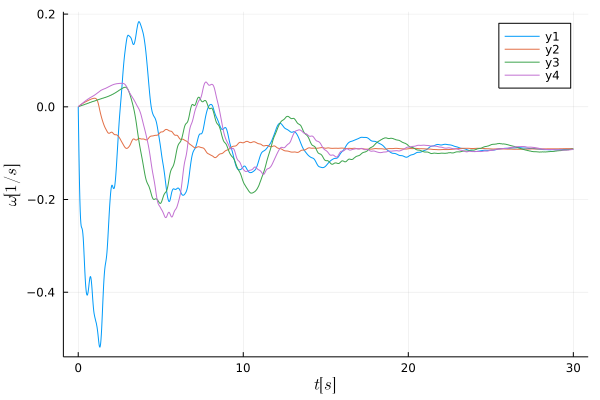

In [20]:
start=1
plot(0:0.02:30,omegas2[20,20,start:end])
plot!(0:0.02:30,omegas2[60,80,start:end])
plot!(0:0.02:30,omegas2[10,100,start:end])
plot!(0:0.02:30,omegas2[24,121,start:end])
xlabel!("\$t[s]\$")
ylabel!("\$\\omega[1/s]\$")